# 1. Change the output layer

In [11]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Define image transformations
image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

In [14]:
# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

In [15]:
# Get the number of input features for the final layer
num_ftrs = model.fc.in_features
print(f"Original number of input features to the final layer: {num_ftrs}")

Original number of input features to the final layer: 512


In [16]:
# Replace the final fully connected layer with a new one for 2 classes
model.fc = nn.Linear(num_ftrs, 2)
print("New final layer architecture:")
print(model.fc)

New final layer architecture:
Linear(in_features=512, out_features=2, bias=True)


# 2. Train the model

In [17]:
# Assuming your dataset is split into 'train' and 'test' directories
train_data_path = 'Dataset/train'
test_data_path = 'Dataset/val'


In [18]:
# Load datasets from directories
train_dataset = datasets.ImageFolder(train_data_path, data_transforms)
test_dataset = datasets.ImageFolder(test_data_path, data_transforms)

In [19]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 2
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch [1/2], Loss: 0.0895, Accuracy: 0.9686
Epoch [2/2], Loss: 0.0789, Accuracy: 0.9724


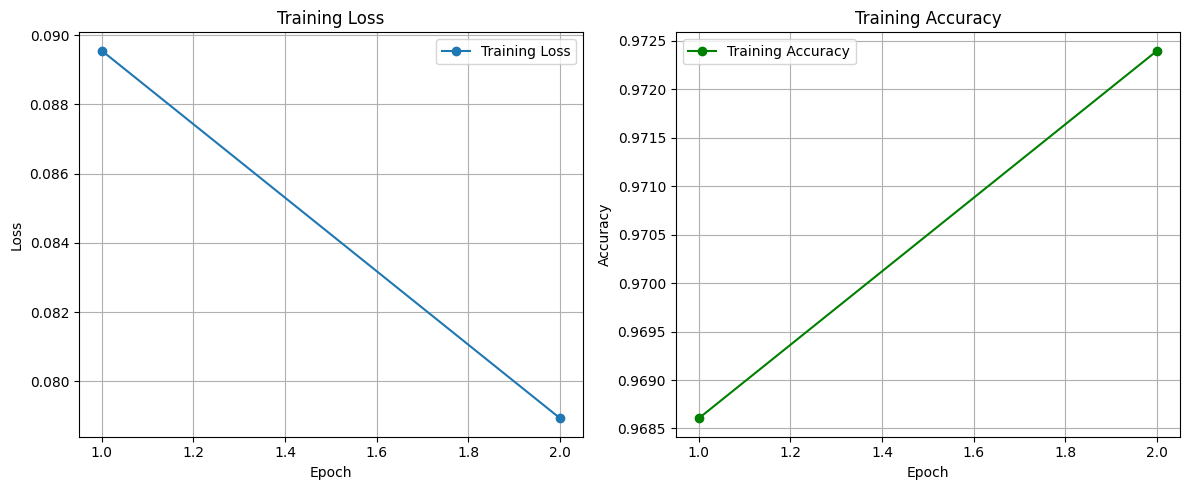

In [22]:
# Plotting the loss and accuracy
epochs = range(1, num_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, train_losses, 'o-', label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, train_accuracies, 'o-', color='green', label='Training Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# plt.savefig('loss_accuracy_plot.png')
plt.show()

# 3. First four misclassified samples

In [23]:
model.eval()
misclassified_samples = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for j in range(len(inputs)):
            if predicted[j] != labels[j]:
                misclassified_samples.append({
                    'sample_index': i * test_loader.batch_size + j,
                    'predicted_value': predicted[j],
                    'actual_value': labels[j]
                })

# Print the first four misclassified samples
print("\nFirst four misclassified samples:")
for sample in misclassified_samples[:4]:
    print(f"sample{sample['sample_index']} predicted value: tensor([{sample['predicted_value']}]), actual value: tensor([{sample['actual_value']}])")


First four misclassified samples:
sample460 predicted value: tensor([1]), actual value: tensor([0])
sample549 predicted value: tensor([0]), actual value: tensor([1])
sample557 predicted value: tensor([0]), actual value: tensor([1])
sample606 predicted value: tensor([0]), actual value: tensor([1])
